<a href="https://colab.research.google.com/github/sarashahin/ML_Research/blob/main/Lung_research_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lung-densenet:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4494764%2F7700190%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240805%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240805T135410Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D209b18f58e4e4d275eab872b934a78aafb69bf2185ca343907ccf1bb99903655f877fbb790edf2268d9ca53a3b3168bd436818353d7a799a433dc84d6b67f4df201b02310d343c757f6269f31b2f4cd29c8a3f586609b9a7246488159151ab68e3d274b9d8d37f44174866ed61c3ba09fb0d55d77889590f84f7b852695761bcc575ff2eeb8d7c585cb82311c83f08a20783d612e21ee9102f1e87c13e4465f711bf5de0647aa7c79c6c3705715d077165db04bd9a1876f93d7dc7846831fef2b7bfd19613d06e76be8d9d374839b9b7a9f2c631b46816b2da72ae6269398e2228fa6f53103922f57bd14dc32c807d701378ea01e0803ed774f1ecabef4e7ace'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
#  Import important Libraries

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import KFold
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import DirectoryIterator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GaussianNoise
from sklearn.metrics import classification_report, accuracy_score


import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns


2024-08-05 13:31:07.578338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 13:31:07.578442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 13:31:07.708638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# initialize the random seed
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
# load the DenseNet121 base model, no the top layer
base_model = DenseNet121(weights='imagenet', include_top=False)


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# freeze/Unfreeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False
# unfreeze some top layers of the base model
for layer in base_model.layers[:4]:
    layer.trainable = True

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# with the path
dataset_path_train = '/kaggle/input/lung-densenet/train 2'
dataset_path_test = '/kaggle/input/lung-densenet/test 2'
train_path = os.path.join(dataset_path_train, 'train')
test_path = os.path.join(dataset_path_test, 'test')


Class: BENIGN
Class: MALIGNANT
Class: NORMAL


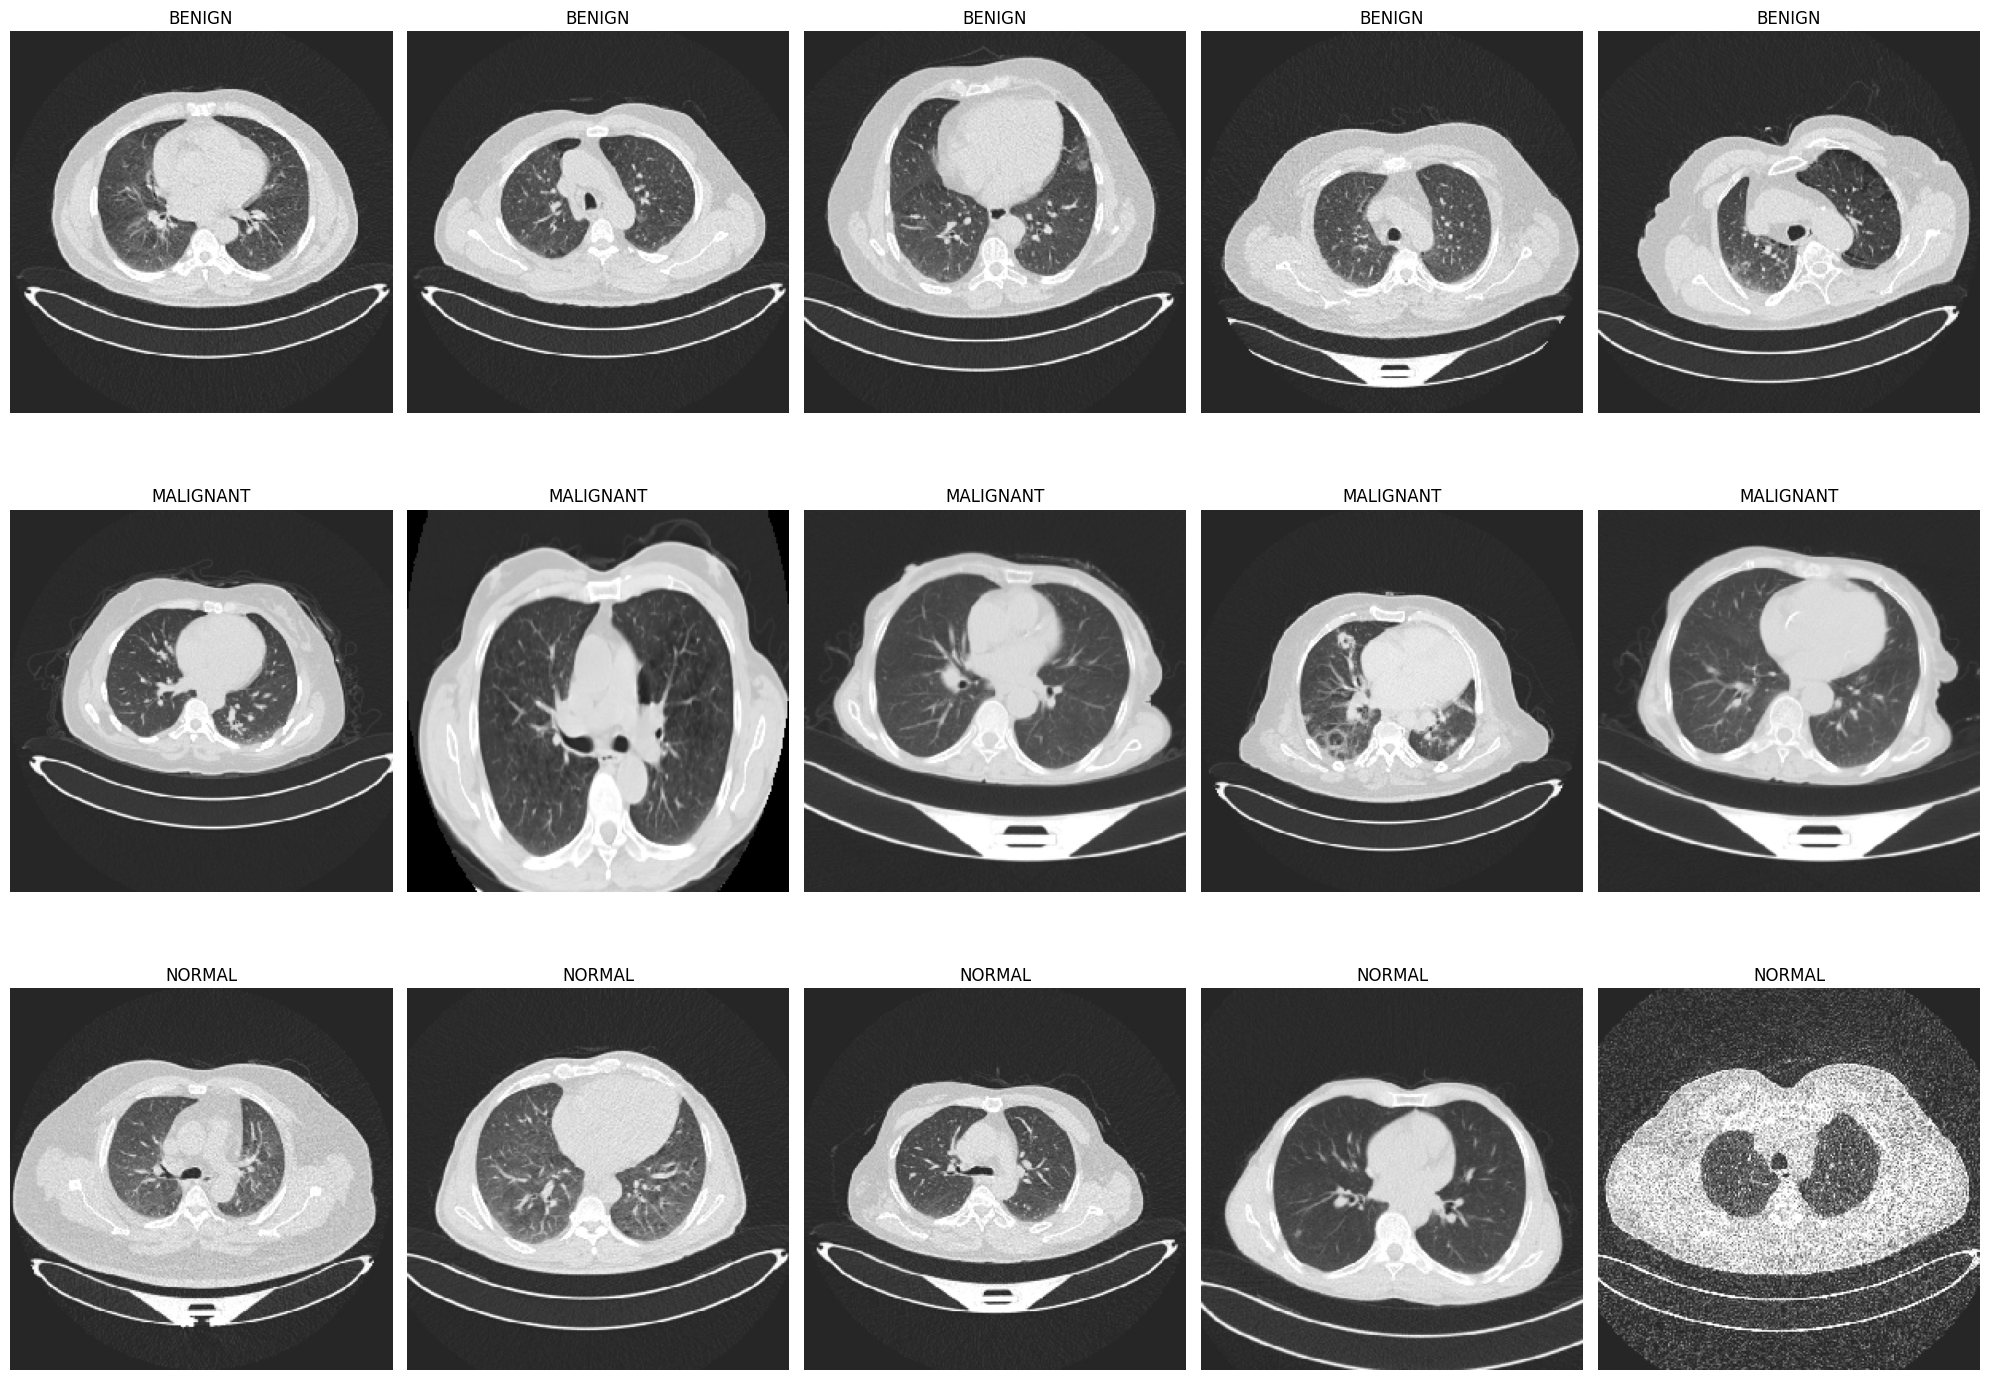

In [ ]:
def display_random_images(class_names, train_path, num_images=5):
    fig, axes = plt.subplots(len(class_names), num_images, figsize=(20, 15))
    for row, cls in enumerate(class_names):
        path = os.path.join(train_path, cls)
        images = os.listdir(path)
        selected_images = random.sample(images, num_images)
        print(f"Class: {cls}")
        for col, img in enumerate(selected_images):
            img_path = os.path.join(path, img)
            image = load_img(img_path, target_size=(240, 240))
            if len(class_names) == 1:
                ax = axes[col]
            else:
                ax = axes[row, col]
            ax.imshow(image)
            ax.set_title(cls)
            ax.axis('off')

    plt.tight_layout()
    plt.show()



class_names = ['BENIGN', 'MALIGNANT', 'NORMAL']
display_random_images(class_names, train_path)

In [ ]:

#  imbalance classes train set

def plot_class_distribution(train_path, class_names):
    class_counts = {}
    for cls in class_names:
        path = os.path.join(train_path, cls)
        count = len(os.listdir(path))
        class_counts[cls] = count

    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of images")
    plt.show()

plot_class_distribution(train_path, class_names)


In [ ]:
def plot_class_distribution(test_path_path, class_names):
    class_counts = {}
    for cls in class_names:
        path = os.path.join(test_path, cls)
        count = len(os.listdir(path))
        class_counts[cls] = count

    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of images")
    plt.show()

plot_class_distribution(test_path, class_names)

In [ ]:
# SNR (dB) = 10 × log ⁡ 10 ( signal power/ noise power )

# power of the signal (image pixel values)

# noise power(variance of the noise)

def calculate_snr(image, snr_db):
    # Calculate signal power
    signal_power = np.mean(image ** 2)

    # Calculate noise power
    noise_power = signal_power / (10 ** (snr_db / 10)) #Convert SNR from dB to linear scale and calculate noise power
    return noise_power


In [ ]:
def add_gaussian_noise(image, snr_db):
    row, col, ch = image.shape
    mean = 0
    noise_power = calculate_snr(image, snr_db)
    sigma = np.sqrt(noise_power)
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy = image + gauss
    return np.clip(noisy, 0, 255)


def add_salt_pepper_noise(image, snr_db):
    row, col, ch = image.shape
    s_vs_p = 0.5
    snr_linear = 10 ** (snr_db / 10) #converting it to a linear scale makes it easier in calculations
    corruption_ratio = 0.20 / (1 + snr_linear) #mapping the SNR to the amount of salt and pepper noise to add to the image
    # using a logarithmic scale for non-linear mapping
    # corruption_ratio = np.log10(1 + snr_linear**2) / np.log10(1 + max(snr_range)**2)  # max(snr_range) for normalization
    amount = corruption_ratio * image.size
    num_salt = np.ceil(amount * s_vs_p).astype(int)
    num_pepper = np.ceil(amount * (1 - s_vs_p)).astype(int)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    image[coords] = 1
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    image[coords] = 0
    return image




In [ ]:
# define SNR range between 30 - 40db
snr_range = np.linspace(20, 30, num=5)

# global variables to log noise details
global_noise_log = []

def custom_preprocessing_function(image):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    snr_db = random.choice(snr_range)
    noise_type = random.choice(['gaussian', 'salt_pepper'])

    # add noise to the image
    if noise_type == 'gaussian':
        image = add_gaussian_noise(image, snr_db)
    else:
        image = add_salt_pepper_noise(image, snr_db)

    # log noise details
    global_noise_log.append({'noise_type': noise_type, 'snr': snr_db})

    return image


In [ ]:
# Define SNR range between 30 - 40db
# snr_range = np.linspace(25, 40, num=5)

# # Global variables to log noise details
# global_noise_log = []

# def custom_preprocessing_function(image):
#     add_noise = random.random() < 0.5  # 50% chance to add noise
#     if add_noise:
#         snr_db = random.uniform(30, 40)  # Random SNR between 30 and 40
#         noise_type = random.choice(['gaussian', 'salt_pepper'])
#         if noise_type == 'gaussian':
#             image = add_gaussian_noise(image, snr_db)
#         else:
#             image = add_salt_pepper_noise(image, snr_db)
#         global_noise_log.append({'noise_type': noise_type, 'snr': snr_db, 'image_added': 'noisy'})
#     else:
#         global_noise_log.append({'noise_type': 'none', 'snr': None, 'image_added': 'clean'})
#     return tf.keras.applications.resnet50.preprocess_input(image)


In [ ]:
# function to display images
def plotImages(images_arr, n_images=5):
    fig, axes = plt.subplots(1, n_images, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype('uint8'))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Using K-Fold cross-validation, the data is split into training and validation sets multiple times. For each split, data generators are created to feed both noisy and clean images into the model for training and evaluation.

In [ ]:
# get all image paths and their labels
def get_images_and_labels(base_dir):
    classes = ['BENIGN', 'MALIGNANT', 'NORMAL']
    images = []
    labels = []
    for cls in classes:
        cls_folder = os.path.join(base_dir, cls)
        cls_images = [os.path.join(cls_folder, filename) for filename in os.listdir(cls_folder)]
        images += cls_images
        labels += [cls] * len(cls_images)
    return images, labels

train_images, train_labels = get_images_and_labels(train_path)

In [ ]:
# create a DataFrame with the file paths and labels
df = pd.DataFrame({'filename': train_images, 'class': train_labels})

In [ ]:
# Define ImageDataGenerators
# is used for data augmentation and preprocessing of training a machine learning model with noisy images
train_datagen_noise = ImageDataGenerator(preprocessing_function=
        custom_preprocessing_function,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        # vertical_flip=True,
        shear_range=0.1,  #
        zoom_range=0.1,
        brightness_range=[0.8,1.2])


In [ ]:
train_datagen_clean = ImageDataGenerator(preprocessing_function=
        preprocess_input,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        # vertical_flip=True,
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.8,1.2])

In [ ]:
val_datagen_clean = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen_noise = ImageDataGenerator(preprocessing_function=custom_preprocessing_function)

In [ ]:
# perform K-Fold Cross-Validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(df)): # loop iterates over each fold//  get the indices of the training and validation sets
    print(f"Running fold {fold + 1}")
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    # Create the generators using flow_from_dataframe
    train_generator_noise = train_datagen_noise.flow_from_dataframe(
        dataframe=train_df, #create training data batches with noise
        directory=None,  #  absolute paths
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    train_generator_clean = train_datagen_clean.flow_from_dataframe(
        dataframe=train_df,
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    val_generator_clean = val_datagen_clean.flow_from_dataframe(
        dataframe=val_df,
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    val_generator_noise = val_datagen_noise.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
    )

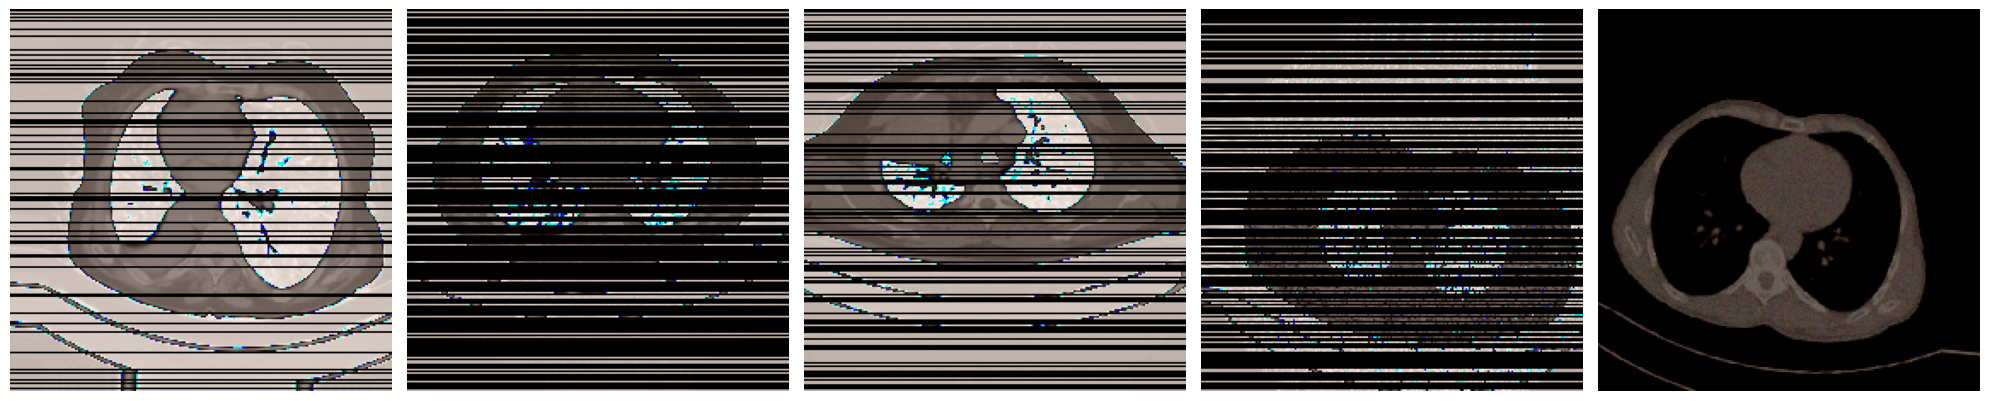

train_generator_clean:


In [ ]:
    # retrieve and display images from the noisy data generator
    print("train_generator_noise:")
    images, labels = next(train_generator_noise)
    plotImages(images[:5])

    print("train_generator_clean:")
    # retrieve and display images from the clean data generator
    images, labels = next(train_generator_clean)
    plotImages(images[:5])

In [ ]:
    # add custom layers on top of the base model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.4))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.4))(x)
    x = Dropout(0.5)(x)
    # x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    # x = Dropout(0.5)(x)  # additional dropout layer
    # add a GaussianNoise layer to simulate and denoise from noise during training
    # x = GaussianNoise(0.1)(x)
    predictions = Dense(3, activation='softmax')(x)  # 3 classes benign, malignant, normal

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)


    model.summary()

 ation)                                                                                           
                                                                                                  
 conv2_block2_1_conv (Conv2  (None, None, None, 128)      12288     ['conv2_block2_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block2_1_bn (BatchNo  (None, None, None, 128)      512       ['conv2_block2_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block2_1_relu (Activ  (None, None, None, 128)      0         ['conv2_block2_1_bn[0][0]']   
 ation)                                                                                           
          

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.68276 to fit



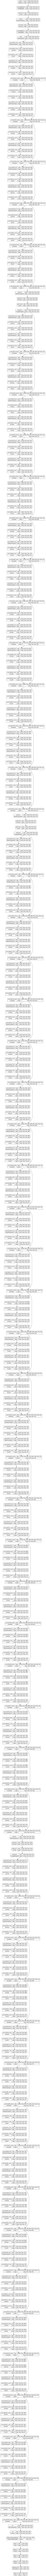

In [ ]:
    plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

In [ ]:
    # class weights for the current training fold/ balancing training set
    train_classes = np.concatenate([train_generator_clean.classes, train_generator_noise.classes])

    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_classes),
        y=train_classes)

    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
    # define the EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # monitor the validation loss
        patience=10, #number of epochs with no improvement the learning rate will be reduced
        verbose=1,    # number of epochs with no improvement after which training will be stopped
        restore_best_weights=True)  # restore model weights from the epoch with the best value of the monitored quantity

In [ ]:
    # use a callback for learning rate scheduling //// avoiding overfitting and can be better convergence during training
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,verbose=1, mode='auto',min_delta=0.0001, cooldown=0, min_lr=0)# min_lr: meaning there is no lower limit

In [ ]:
    model_checkpoint_clean = ModelCheckpoint('clean_best_model.h5', save_best_only=True)  # Save the best model
    model_checkpoint_noise = ModelCheckpoint('noise_best_model.h5', save_best_only=True)  # Save the best model

In [ ]:
    # visualize noise impact on the model validation accuracy over epochs.
    # visualize noise fluctuation during the training(noisy) plot and

    class NoiseScheduler(tf.keras.callbacks.Callback):
        def __init__(self, snr_range, noise_types):
            super(NoiseScheduler, self).__init__()
            self.snr_range = snr_range
            self.noise_types = noise_types
            self.snr_log = []
            self.noise_type_log = []  # Log for noise types
            self.validation_accuracy = []
            self.epoch_log = []  # Log for epoch numbers

        def on_epoch_begin(self, epoch, logs=None):
            # Randomly select SNR and noise type for the current epoch
            snr_db = random.choice(self.snr_range)
            noise_type = random.choice(self.noise_types)
            self.snr_log.append(snr_db)
            self.noise_type_log.append(noise_type)  # Log the noise type

        def on_epoch_end(self, epoch, logs=None):
            val_acc = logs['val_accuracy'] if 'val_accuracy' in logs else None
            self.validation_accuracy.append(val_acc)
            self.epoch_log.append(epoch + 1)  # Log the epoch number
            # Log the SNR value and noise type
            print(f"Epoch {epoch+1} - SNR: {self.snr_log[-1]} dB, Noise Type: {self.noise_type_log[-1]}")

        def on_train_end(self, logs=None):
            # Plot SNR values, noise type, and validation accuracy over epochs
            epochs = list(range(1, len(self.validation_accuracy) + 1))
            fig, ax1 = plt.subplots()

            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('SNR (dB)', color='tab:red')
            ax1.plot(epochs, self.snr_log, color='tab:red', marker='o', label='SNR (dB)')
            ax1.tick_params(axis='y', labelcolor='tab:red')

            # Add a second y-axis for noise type, categorical
            ax2 = ax1.twinx()
            noise_type_values = [self.noise_types.index(nt) for nt in self.noise_type_log]  # Convert noise types to numeric values for plotting
            ax2.set_ylabel('Noise Type', color='tab:green')
            ax2.scatter(epochs, noise_type_values, color='tab:green', label='Noise Type')
            ax2.tick_params(axis='y', labelcolor='tab:green')

            # Add a third yaxis for validation accuracy
            ax3 = ax1.twinx()
            ax3.spines['right'].set_position(('outward', 60))
            ax3.set_ylabel('Validation Accuracy', color='tab:blue')
            ax3.plot(epochs, self.validation_accuracy, color='tab:blue', marker='x', label='Validation Accuracy')
            ax3.tick_params(axis='y', labelcolor='tab:blue')

            fig.tight_layout()
            plt.title('SNR, Noise Type, and Validation Accuracy over Epochs')
            plt.show()





In [ ]:
    # train the model on the training dataset and validate on the validation dataset
    history_clean = model.fit(
        train_generator_clean,
        epochs=20,
        validation_data=val_generator_clean,
        callbacks=[early_stopping,lr_scheduler, model_checkpoint_clean],
        class_weight=class_weights_dict

        )

Epoch 1/20


I0000 00:00:1722864735.023916     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 [==============================] - ETA: 0s - loss: 638.9506 - accuracy: 0.5403 - precision: 0.5753 - recall: 0.4620 - auc: 0.7251

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 96s 854ms/step - loss: 638.9506 - accuracy: 0.5403 - precision: 0.5753 - recall: 0.4620 - auc: 0.7251 - val_loss: 591.8896 - val_accuracy: 0.6374 - val_precision: 0.7638 - val_recall: 0.4480 - val_auc: 0.8364 - lr: 1.0000e-04
Epoch 2/20
28/28 [==============================] - 19s 675ms/step - loss: 551.4025 - accuracy: 0.6959 - precision: 0.7251 - recall: 0.6532 - auc: 0.8753 - val_loss: 510.2823 - val_accuracy: 0.7921 - val_precision: 0.8283 - val_recall: 0.7021 - val_auc: 0.9272 - lr: 1.0000e-04
Epoch 3/20
28/28 [==============================] - 19s 676ms/step - loss: 475.0382 - accuracy: 0.7776 - precision: 0.8073 - recall: 0.7385 - auc: 0.9324 - val_loss: 439.2395 - val_accuracy: 0.6651 - val_precision: 0.6907 - val_recall: 0.6189 - val_auc: 0.8517 - lr: 1.0000e-04
Epoch 4/20
28/28 [==============================] - 19s 679ms/step - loss: 408.5458 - accuracy: 0.8445 - precision: 0.8710 - recall: 0.8088 - auc: 0.9618 - val_loss: 376.8841 - 

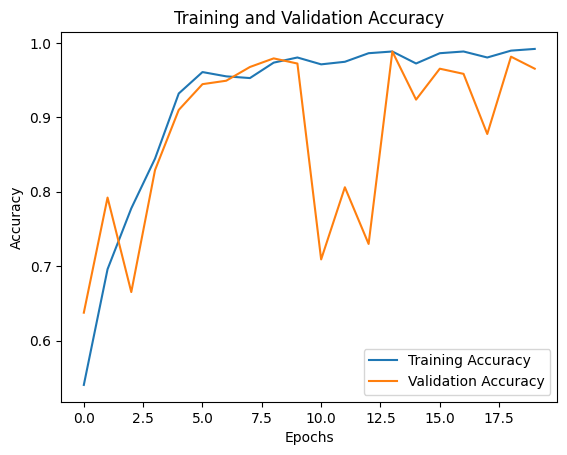

In [ ]:
    # Plotting training and validation accuracies for clean
    plt.plot(history_clean.history['accuracy'], label='Training Accuracy')
    plt.plot(history_clean.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Epoch 1/20
28/28 [==============================] - 22s 815ms/step - loss: 21.0866 - accuracy: 0.7212 - precision: 0.8090 - recall: 0.6244 - auc: 0.8849 - val_loss: 19.1737 - val_accuracy: 0.6582 - val_precision: 0.7413 - val_recall: 0.5427 - val_auc: 0.8373 - lr: 1.0000e-04
Epoch 2/20
28/28 [==============================] - 22s 785ms/step - loss: 17.2546 - accuracy: 0.7765 - precision: 0.8442 - recall: 0.7177 - auc: 0.9279 - val_loss: 15.7339 - val_accuracy: 0.6859 - val_precision: 0.7109 - val_recall: 0.6189 - val_auc: 0.8567 - lr: 1.0000e-04
Epoch 3/20
28/28 [==============================] - 22s 777ms/step - loss: 14.0715 - accuracy: 0.8376 - precision: 0.9020 - recall: 0.7742 - auc: 0.9601 - val_loss: 12.7391 - val_accuracy: 0.7436 - val_precision: 0.7720 - val_recall: 0.6882 - val_auc: 0.9154 - lr: 1.0000e-04
Epoch 4/20
28/28 [==============================] - 22s 786ms/step - loss: 11.4303 - accuracy: 0.8537 - precision: 0.8961 - recall: 0.8249 - auc: 0.9718 - val_loss: 10.4615

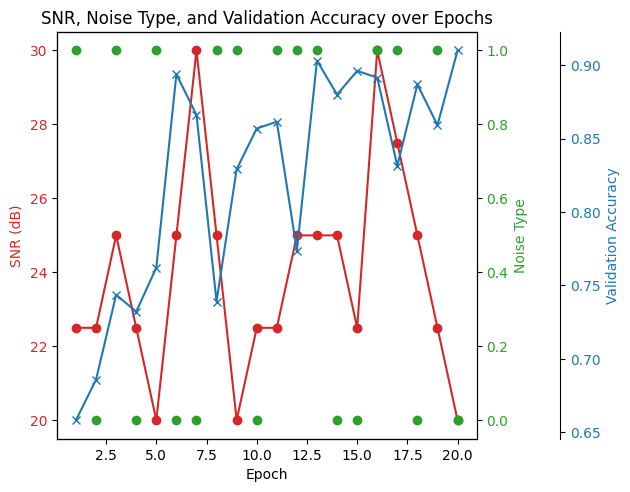

In [ ]:

    # define SNR range and noise types for the NoiseScheduler
    snr_range = np.linspace(20, 30, num=5)
    noise_types = ['gaussian', 'salt_pepper']

    # noiseScheduler with the SNR range and noise types
    noise_scheduler = NoiseScheduler(snr_range, noise_types)

    # fit the model
    history_noisy = model.fit(
        train_generator_noise,
        epochs=20,
        validation_data=val_generator_noise,
        callbacks=[noise_scheduler, early_stopping, lr_scheduler, model_checkpoint_noise],
        class_weight=class_weights_dict
    )


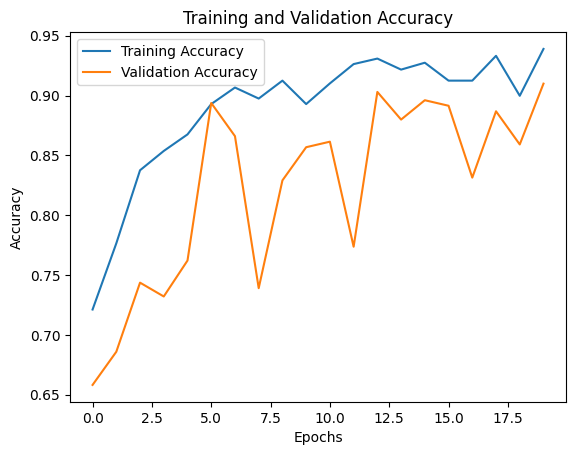

In [ ]:
    # Plotting training and validation accuracies for noise
    plt.plot(history_noisy.history['accuracy'], label='Training Accuracy')
    plt.plot(history_noisy.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
    results_df = pd.DataFrame({
        'Epoch': noise_scheduler.epoch_log,
        'SNR': noise_scheduler.snr_log,
        'Noise_Type': noise_scheduler.noise_type_log,
        'Validation_Accuracy': noise_scheduler.validation_accuracy
    })

    # Display the DataFrame
    print(results_df)

    Epoch   SNR   Noise_Type  Validation_Accuracy
0       1  22.5  salt_pepper             0.658199
1       2  22.5     gaussian             0.685912
2       3  25.0  salt_pepper             0.743649
3       4  22.5     gaussian             0.732102
4       5  20.0  salt_pepper             0.762125
5       6  25.0     gaussian             0.893764
6       7  30.0     gaussian             0.866051
7       8  25.0  salt_pepper             0.739030
8       9  20.0  salt_pepper             0.829099
9      10  22.5     gaussian             0.856813
10     11  22.5  salt_pepper             0.861432
11     12  25.0  salt_pepper             0.773672
12     13  25.0  salt_pepper             0.903002
13     14  25.0     gaussian             0.879908
14     15  22.5     gaussian             0.896074
15     16  30.0  salt_pepper             0.891455
16     17  27.5  salt_pepper             0.831409
17     18  25.0     gaussian             0.886836
18     19  22.5  salt_pepper             0.859122


In [ ]:
# function to create test data generators

def create_test_generators(batch_size=32):

    clean_test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

    noise_test_datagen = ImageDataGenerator(preprocessing_function=custom_preprocessing_function)

    clean_test_generator = clean_test_datagen.flow_from_directory(
        test_path,  # Path to clean test data
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # for evaluation
    )

    noise_test_generator = noise_test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # retrieve and display images from the noisy data generator
    print("clean_test_generator:")
    images, labels = next(clean_test_generator)
    plotImages(images[:5])

    print("Noise_test_generator:")
    # retrieve and display images from the clean data generator
    images, labels = next(noise_test_generator)
    plotImages(images[:5])

    return clean_test_generator, noise_test_generator

In [ ]:
class_names = ['benign', 'malignant', 'normal']

def evaluate_model(model, generator, steps, class_names):
    # reset the generator to ensure its at the beginning
    generator.reset()
    # predict on the entire dataset
    predictions = model.predict(generator, steps=steps)
    # Get the highest probability class as the predicted class
    predicted_classes = np.argmax(predictions, axis=1)
    # True classes from the generator
    true_classes = generator.classes
    # Print the classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_names))
    # Calculate and print accuracy
    accuracy = accuracy_score(true_classes, predicted_classes)
    print(f'Accuracy: {accuracy * 100:.2f}%')

In [ ]:
# Evaluate the model
model.load_weights('clean_best_model.h5')  # Load the best model saved by ModelCheckpoint

Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
clean_test_generator:


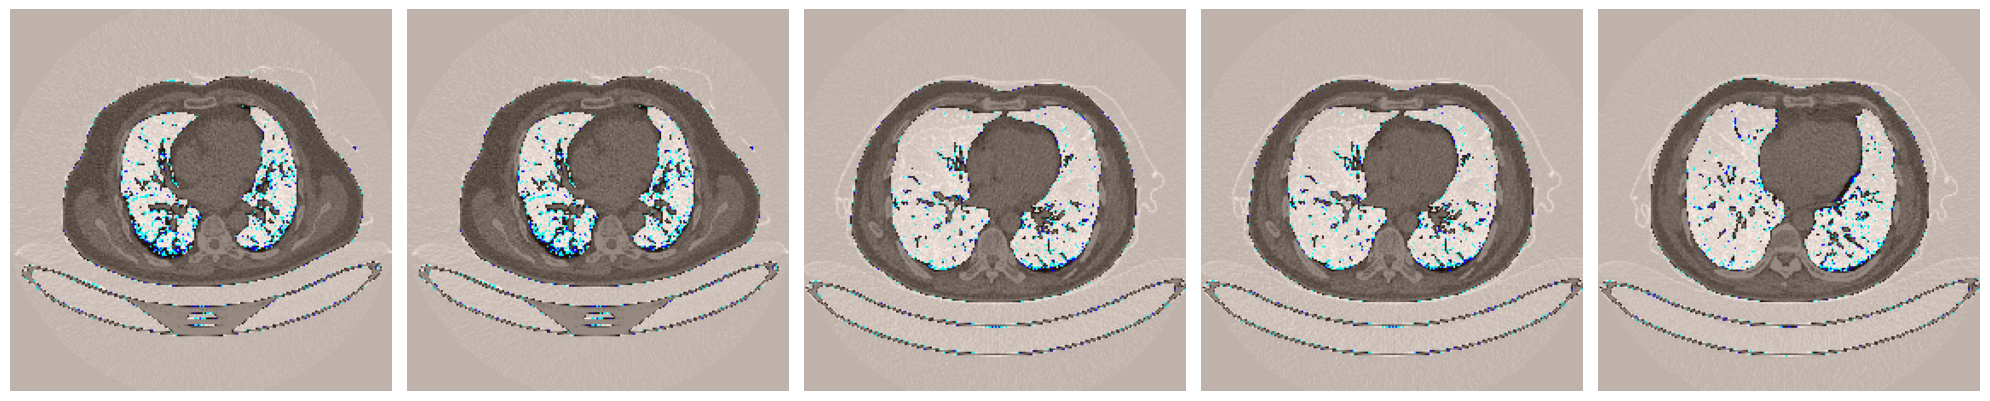

Noise_test_generator:


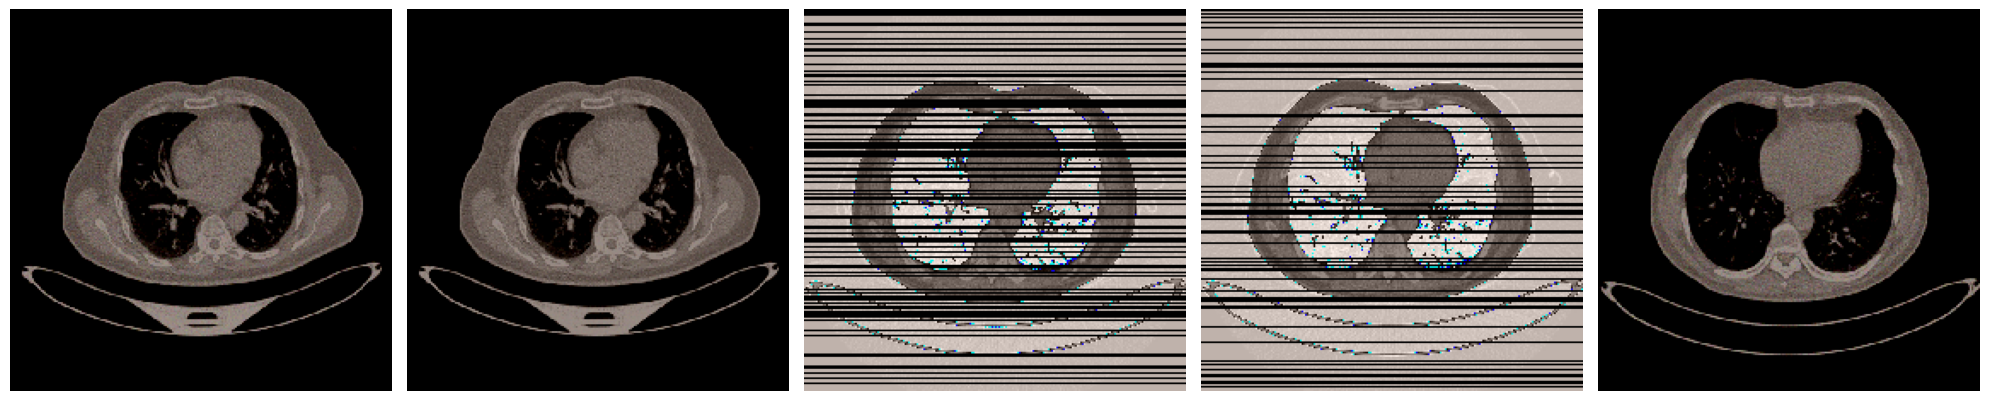

In [ ]:
# import pandas as pd

# Reset the global noise log before evaluation
global_noise_log = []

clean_test_gen, noise_test_gen = create_test_generators(batch_size=32)




In [ ]:
# Evaluate on clean test data

clean_test_loss, clean_test_accuracy, clean_test_precision, clean_test_recall, clean_test_auc = model.evaluate(clean_test_gen, verbose=1)
print(f"Clean Test Accuracy: {clean_test_accuracy * 100:.2f}%%, Precision: {clean_test_precision}, Recall: {clean_test_recall}, AUC: {clean_test_auc}")

10/10 [==============================] - 5s 525ms/step - loss: 23.7455 - accuracy: 0.6533 - precision: 0.6577 - recall: 0.6533 - auc: 0.7719
Clean Test Accuracy: 65.33%%, Precision: 0.6577181220054626, Recall: 0.653333306312561, AUC: 0.7718806266784668


In [ ]:
# For Clean Test Data
print("Evaluation on Clean Test Data:")
evaluate_model(model, clean_test_gen, len(clean_test_gen), class_names)

Evaluation on Clean Test Data:
10/10 [==============================] - 3s 148ms/step
              precision    recall  f1-score   support

      benign       0.59      0.20      0.30       100
   malignant       0.97      0.93      0.95       100
      normal       0.49      0.83      0.61       100

    accuracy                           0.65       300
   macro avg       0.68      0.65      0.62       300
weighted avg       0.68      0.65      0.62       300

Accuracy: 65.33%


In [ ]:
# Evaluate the model
model.load_weights('noise_best_model.h5')  # Load the best model saved by ModelCheckpoint

In [ ]:
# # Evaluate on noisy test data
noise_test_loss, noise_test_accuracy, noise_test_precision, noise_test_recall, noise_test_auc = model.evaluate(noise_test_gen, verbose=1)
print(f"Noisy Test Accuracy: {noise_test_accuracy * 100:.2f}%, Precision: {noise_test_precision}, Recall: {noise_test_recall}, AUC: {noise_test_auc}")

# Create a DataFrame to store metrics with noise details
metrics_df = pd.DataFrame(global_noise_log)
metrics_df['Accuracy'] = noise_test_accuracy
metrics_df['Precision'] = noise_test_precision
metrics_df['Recall'] = noise_test_recall
metrics_df['AUC'] = noise_test_auc

# Display the DataFrame
print(metrics_df)

10/10 [==============================] - 2s 219ms/step - loss: 1.1434 - accuracy: 0.7100 - precision: 0.7182 - recall: 0.6967 - auc: 0.8442
Noisy Test Accuracy: 71.00%, Precision: 0.7182130813598633, Recall: 0.6966666579246521, AUC: 0.8441805243492126
      noise_type   snr  Accuracy  Precision    Recall       AUC
0       gaussian  22.5      0.71   0.718213  0.696667  0.844181
1       gaussian  30.0      0.71   0.718213  0.696667  0.844181
2    salt_pepper  27.5      0.71   0.718213  0.696667  0.844181
3    salt_pepper  30.0      0.71   0.718213  0.696667  0.844181
4       gaussian  20.0      0.71   0.718213  0.696667  0.844181
..           ...   ...       ...        ...       ...       ...
359     gaussian  30.0      0.71   0.718213  0.696667  0.844181
360     gaussian  27.5      0.71   0.718213  0.696667  0.844181
361     gaussian  22.5      0.71   0.718213  0.696667  0.844181
362     gaussian  30.0      0.71   0.718213  0.696667  0.844181
363     gaussian  27.5      0.71   0.718213 

In [ ]:
# For Cnoise Test Data
print("Evaluation on Noise Test Data:")
evaluate_model(model, noise_test_gen, len(noise_test_gen), class_names)

Evaluation on Noise Test Data:
10/10 [==============================] - 2s 220ms/step
              precision    recall  f1-score   support

      benign       0.56      0.59      0.58       100
   malignant       0.99      0.85      0.91       100
      normal       0.61      0.66      0.63       100

    accuracy                           0.70       300
   macro avg       0.72      0.70      0.71       300
weighted avg       0.72      0.70      0.71       300

Accuracy: 70.00%


 Precision: measures the ratio of correctly predicted positive observations to the total predicted positives.

 Recal: actual positive cases were correctly identified by the model.

 AUC: good ability of the model to distinguish between classes.

References:


https://medium.com/@dnyaneshwalwadkar/fix-training-accuracy-fluctuation-over-fitting-problem-in-deep-learning-algorithm-859573090809

\

https://github.com/MedMachine00/Deep-learning-based-coronary-artery-segmentation/tree/main

\

https://github.com/Paperspace/DataAugmentationForObjectDetection/blob/master/quick-start.ipynb


\


https://www.researchgate.net/publication/352806683_Image_De-Noising_with_Machine_Learning_A_Review#:~:text=This%20paper%20explores%20the%20numerous,networks%20and%20generative%20adversarial%20networks

\
https://arxiv.org/pdf/1609.03683.pdf

\

https://keras.io/api/

\

https://www.researchgate.net/publication/371699794_Deep_learning_techniques_on_3D-MRI_lung_images_for_detection_and_segmentation_of_COVID-19_virus

\
https://link.springer.com/article/10.1007/s10462-023-10453-z#Sec21

\
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7085309/


\
https://mrimaster.com/snr/

\

https://radiopaedia.org/articles/signal-to-noise-ratio-mri?lang=gb

\
https://gist.github.com/Prasad9/28f6a2df8e8d463c6ddd040f4f6a028a?ref=blog.roboflow.com

\
Litjens, Geert, et al. "A survey on deep learning in medical image analysis." Medical image analysis 42 (2017)


Ker, Justin, et al. "Deep learning applications in medical image analysis." IEEE Access 6 (2018).

https://debuggercafe.com/adding-noise-to-image-data-for-deep-learning-data-augmentation/

signal-to-noise ratio (SNR) in dB. SNR is calculated using the formula:

SNR (dB)
=
10
×
log
⁡
10
(
signal power/
noise power
)

power of the signal (image pixel values)

noise power(variance of the noise)

Next steps:\
1- should tune the model to get better accuracy on test set

2- try diferent models like DenseNet, more suitable for this task because advantages of feature reuse.

3- try advanced data augmentation techniques like rotation, skewing, or elastic deformations.

4- try automated hyperparameter tuning methods like grid search or Bayesian optimization can systematically find the best parameters.

5- try advanced noise models like motion blur, low-dose artifacts and low-light conditions

6- try ensemble methods, combining the outputs of multiple models can improve overall performance. averaging the predictions.

7- try hybrid approach, traditional machine learning classifiers (like SVM or Random Forest) for the final classification task.

8- try hyperparameter tuning, use tools like Keras Tuner or Hyperopt for automated hyperparameter optimization.